In [ ]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### State

In [191]:
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict


class State(TypedDict):
    messages: Annotated[list, add_messages]

### 상담사 chatbot

In [172]:
from typing import List

from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

from langchain_core.prompts import MessagesPlaceholder

from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage
from langchain_core.messages import BaseMessage


def call_chatbot(messages: List[BaseMessage]) -> dict:
    print('==================================================================================================')
    print(f'===== [상담사 chatbot] call_chatbot() =====')

    # print(f'[고객 질문]: ')
    # print(messages)
    
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                'system',
                'You are a customer support agent for an airline. Answer in Korean.'
            ),
            MessagesPlaceholder(variable_name='messages') 
        ]        
    )

    llm = ChatOpenAI(
        api_key=key, 
        model='gpt-4o-mini', 
        temperature=0.6
    )

    chain = prompt | llm | StrOutputParser()
    answer = chain.invoke({"messages": messages})
    # print('답변: ')
    # print(answer)
    print('==================================================================================================\n')

    return answer

In [173]:
messages = [('user', '안녕하세요?')]
call_chatbot(messages)

===== [상담사 chatbot] call_chatbot() =====



'안녕하세요! 어떻게 도와드릴까요?'

In [174]:
messages = [HumanMessage(content='안녕하세요?')]
call_chatbot(messages)

===== [상담사 chatbot] call_chatbot() =====



'안녕하세요! 무엇을 도와드릴까요?'

### 메시지의 역할 교체

In [175]:
def _swap_roles(messages):          #  메시지 타입을 AI -> Human, Human -> AI 로 교체
    
    new_messages = []

    for m in messages:
        if isinstance(m, AIMessage):            
            # AIMessage 인 경우, HumanMessage 로 변환합니다.            
            new_messages.append(HumanMessage(content=m.content))
        else:                                   
            # HumanMessage 인 경우, AIMessage 로 변환합니다.            
            new_messages.append(AIMessage(content=m.content))

    return new_messages

### 상담사 노드

In [176]:
def ai_assistant_node(state: State):
    print('==================================================================================================')
    print(f'===== [상담사 노드] ai_assistant_node =====')
    
    # print(f"고객 질문: ")
    # print(state["messages"])

    ai_response = call_chatbot(state["messages"])       # 상담사 챗봇 호출
   
    # print(f"상담사 답변: ")
    # print(ai_response)

    print('==================================================================================================\n')

    return {"messages": [("assistant", ai_response)]}

### 고객이 사용할 시나리오

In [177]:
def create_scenario(name: str, instructions: str):
    system_prompt_template = """You are a customer of an airline company. \
You are interacting with a user who is a customer support person. \

Your name is {name}.

# Instructions:
{instructions}

[IMPORTANT] 
- When you are finished with the conversation, respond with a single word 'FINISHED'
- You must speak in Korean."""


    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt_template),
            MessagesPlaceholder(variable_name="messages")
        ]
    )

    prompt = prompt.partial(name=name, instructions=instructions)

    return prompt

In [178]:
instructions = """You are trying to get a refund for the trip you took to Jeju Island. \
You want them to give you ALL the money back. This trip happened last year."""

name = '홀길동'

# create_scenario(name, instructions).pretty_print()

llm = ChatOpenAI(
    api_key=key, 
    model='gpt-4o-mini', 
    temperature=0.6
)

simulated_user = create_scenario(name, instructions) | llm | StrOutputParser()

### 사용자 노드

In [179]:
def simulated_user_node(state: State):

    print('==================================================================================================')
    print(f'===== [고객 노드] simulated_user_node() =====')
    
    new_messages = _swap_roles(state["messages"])

    # print(f"사용자 질문: ")
    # print(new_messages)

    response = simulated_user.invoke({'messages': new_messages})

    # print(f"답변: ")
    # print(response)
    print('==================================================================================================\n')

    return {'messages': [('user', response)]}

In [180]:
inputs = {
    "messages": [AIMessage(content="무엇을 도와드릴까요?")]
    
}

simulated_user_node(inputs)

===== [고객 노드] simulated_user_node() =====



{'messages': [('user',
   '안녕하세요. 작년에 제주도로 여행을 갔었는데, 그 여행에 대한 환불을 요청하고 싶습니다. 모든 돈을 돌려받고 싶습니다. 도와주실 수 있나요?')]}

In [181]:
def should_continue(state: State):
    print('\n==================================================================================================')
    print(f'===== [계속 실행] should_continue() =====')

    if len(state["messages"]) > 6:
        print('end')
        return "end"
    elif state["messages"][-1].content == "FINISHED":
        print('end')
        return "end"
    else:
        print('continue')
        return "continue"

In [182]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import StateGraph, END

In [183]:
######### 1. 그래프 생성 #########

graph_builder = StateGraph(State)

In [184]:
######### 2. 노드 정의  #########

graph_builder.add_node('simulated_user', simulated_user_node)
graph_builder.add_node('ai_assistant', ai_assistant_node)

In [185]:
######### 3. 그래프 엣지(Edge) 추가  #########

graph_builder.add_edge('ai_assistant', 'simulated_user')

In [186]:
graph_builder.add_conditional_edges(
    "simulated_user",
    should_continue,
    {
        "end": END,                     
        "continue": "ai_assistant", 
    },
)

In [187]:
######### 4. 그래프 진입점  #########

graph_builder.set_entry_point('ai_assistant')

In [188]:
######### 5. 그래프 컴파일(compile)  #########

simulation = graph_builder.compile()

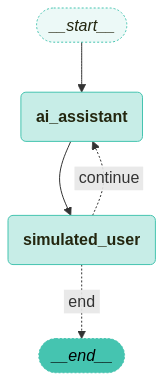

In [189]:
visualize_graph(simulation)

In [190]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

# 입력 메시지 설정
inputs = {
    "messages": [HumanMessage(content="안녕하세요? 저 지금 좀 화가 많이 났습니다^^")]
}


for event in simulation.stream(inputs, config=config):
    for node_name, node_chunk in event.items():
        print('[node_name]:', node_name)
        print('[node_chunk]:\n', node_chunk)

===== [상담사 노드] ai_assistant_node =====
===== [상담사 chatbot] call_chatbot() =====


[node_name]: ai_assistant
[node_chunk]:
 {'messages': [('assistant', '안녕하세요! 저희 항공사에 문의해 주셔서 감사합니다. 무엇 때문에 화가 나셨는지 말씀해 주시면, 최대한 도와드리도록 하겠습니다. 어떤 문제가 있으신가요?')]}
===== [고객 노드] simulated_user_node() =====


===== [계속 실행] should_continue() =====
continue
[node_name]: simulated_user
[node_chunk]:
 {'messages': [('user', '작년 제주도 여행에 대한 환불을 요청하고 싶습니다. 여행이 정말 실망스러웠고, 전액 환불을 받고 싶어요.')]}
===== [상담사 노드] ai_assistant_node =====
===== [상담사 chatbot] call_chatbot() =====


[node_name]: ai_assistant
[node_chunk]:
 {'messages': [('assistant', '죄송합니다. 제주도 여행에 대한 실망스러운 경험에 대해 듣게 되어 유감입니다. 환불 요청을 진행하기 위해 몇 가지 정보를 필요로 합니다. 예약 번호와 여행 날짜를 알려주실 수 있으신가요? 그리고 환불 사유에 대해서도 조금 더 자세히 말씀해 주시면 감사하겠습니다. 최대한 빠르게 도와드리겠습니다.')]}
===== [고객 노드] simulated_user_node() =====


===== [계속 실행] should_continue() =====
continue
[node_name]: simulated_user
[node_chunk]:
 {'messages': [('user', '예약 번호는 123456이고, 여행 날짜는 작년 5월 15일이었습니다. 환불 사유는 서비스가 매우 불만족